# Beer Styles

We investigate the impact of the beer styles on the grades and season (winter/summer).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.formula.api as smf
from wordcloud import WordCloud

In [2]:
DATA_PATH = './datasets/BeerAdvocate/'
reviews = pd.read_pickle(DATA_PATH + 'reviews.pkl')

We are interested in season behaviour, so we append the colum that represents the month in which the beer is reviewed. We consider summer as July, August and September, while the winter months are January, February and March.

In [3]:
reviews['Month'] = reviews.Date.dt.month
reviews['Summer'] = reviews.Month.apply(lambda x : 1 if x in [7, 8, 9] else 0)
reviews['Winter'] = reviews.Month.apply(lambda x : 1 if x in [1, 2, 3] else 0)

In [4]:
dict(reviews.groupby('Month').mean()['Overall'])

{1: 3.8601833453566714,
 2: 3.863683715461493,
 3: 3.859058013999288,
 4: 3.8601285682745923,
 5: 3.851729926604999,
 6: 3.8394068056190416,
 7: 3.833004829355085,
 8: 3.8316860743722447,
 9: 3.831455586242587,
 10: 3.8385455469866905,
 11: 3.8404608610616084,
 12: 3.8401814504374814}

Iverall people give higher grades in winter and we wish to deeper investigate this phenomenon. 

In [5]:
summer_df = reviews[reviews.Summer == 1]
winter_df = reviews[reviews.Winter == 1]

print('# reviews in Summer : {}'.format(len(summer_df)))
print('# reviews in Winter : {}'.format(len(winter_df)))
print('% increase of number of reviews in winter : {:.2f}%'.format((len(winter_df)/len(summer_df)-1)*100))
      

# reviews in Summer : 631219
# reviews in Winter : 677421
% increase of number of reviews in winter : 7.32%


People give more reviews in winter!

##### What styles are popular in which season?

In [6]:
# group the data by beer style, and calculate the number of reviews for each style, take 15 most popular per season
top_summer_styles = summer_df.groupby('Style')['Date'].count().sort_values(ascending=False).head(15)
top_summer_styles = pd.DataFrame(top_summer_styles.rename('SummerFrequency'))
top_winter_styles = winter_df.groupby('Style')['Date'].count().sort_values(ascending=False).head(15)
top_winter_styles = pd.DataFrame(top_winter_styles.rename('WinterFrequency'))

Visualize the most popular styles during summer and winter!

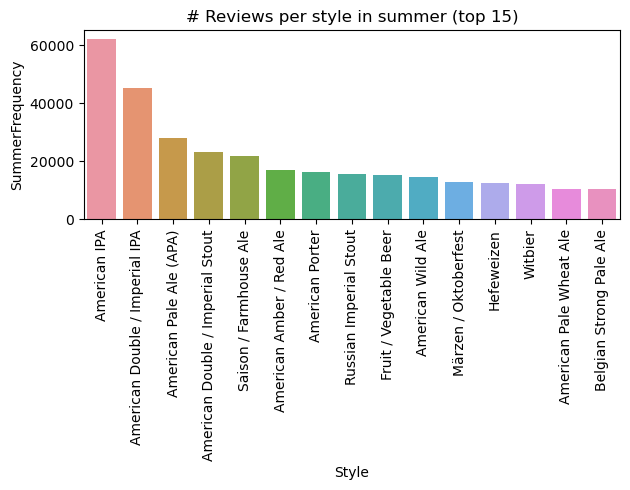

In [7]:
sns.barplot(data=top_summer_styles, x=top_summer_styles.index, y=top_summer_styles.SummerFrequency)
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('# Reviews per style in summer (top 15)')
plt.show()

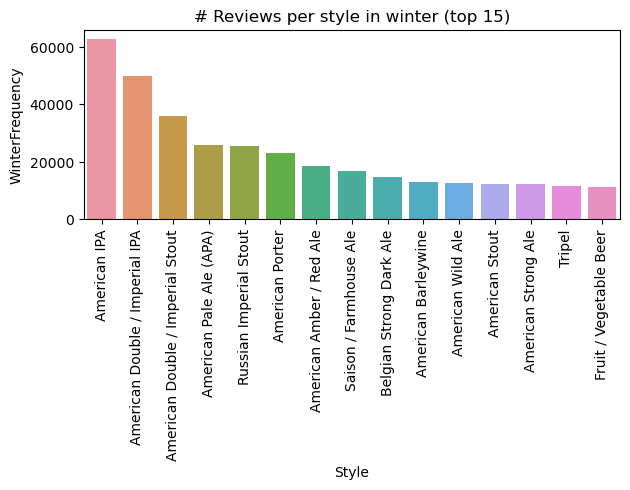

In [8]:
sns.barplot(data=top_winter_styles, x=top_winter_styles.index, y=top_winter_styles.WinterFrequency)
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('# Reviews per style in winter (top 15)')
plt.show()

We conclude that 4 most popular styles are the same in the summer and in the winter. However, there is a change in 3rd and 4th place between the seasons. Namely, American Double / Imperial Stout and American Pale Ale (APA) swap their positions and frequencies. Note: 
- American Double / Imperial Stout  (3rd in winter, 4th in summer) : there is an increase of 56% more reviews in winter
- American Pale Ale (APA) the only out of top 4 has decrease in winter (-11.3%)
Notes:
- Russian Imperial Stout (5th in winter, 8th in summer), winter increase in reviews : 65%
- Fruit / Vegetable Beer (9th in summer, 15th in winter), winter decrease in reviews : 25.7%
- Märzen / Oktoberfest does not even appear for top winter

Therefore, people review (and probably drink) different styles between the seasons.

##### Let's investigate the ratings of the popular styles

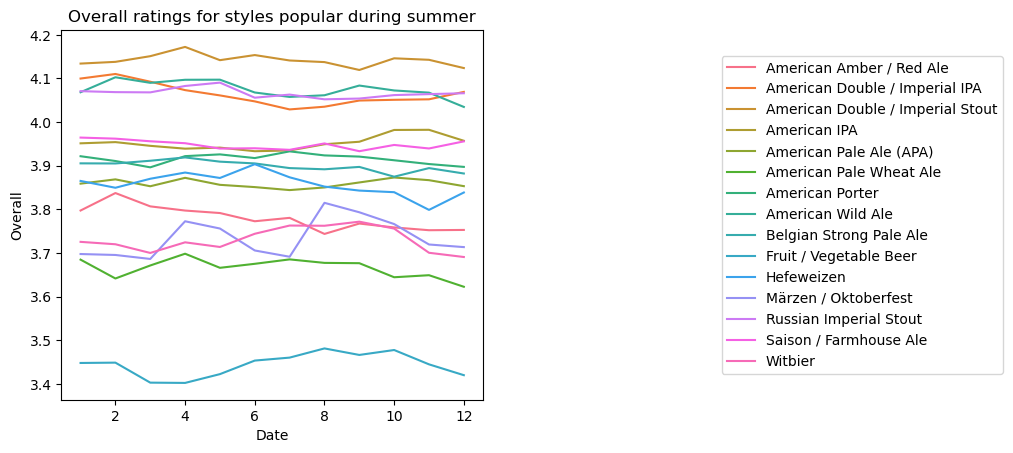

In [9]:
selected = reviews[reviews.Style.isin(top_summer_styles.index.to_list())]
monthly_trends_summer_pop = selected.groupby(['Style', reviews['Date'].dt.month])['Overall'].mean()
df = pd.DataFrame(monthly_trends_summer_pop).reset_index()
g = sns.lineplot(data=df, x='Date', y='Overall', hue='Style')
box = g.get_position()
g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
g.legend(loc='center right', bbox_to_anchor=(2.25, 0.5), ncol=1)
plt.title('Overall ratings for styles popular during summer')
plt.show()

We see that differences between ratings among the styles are considerable. For example, we concluded Fruit/Vegetable beers are popular during summer, but they overall tend to have lower ratings. We conclude the same for style Märzen / Oktoberfest. For these 2 styles we obtain a Simpson paradox. That is, the overall trend of grades decreases in the summer, but we see that per style the trend for these 2 groups are increasing.

#### BUT : WHY ARE PEOPLE GRADING DIFFERENTLY THE SAME STYLES IN DIFFERENT SEASONS?

##### Let's first find out what are the styles in which there is a significant difference between grades in summer and winter:

We define a significant difference between sesons in a style for a beer aspect if :
- The difference between the means of ratings in summer and winter is greater than 0.05
- The p-value that corresponds the season indicator column in the linear regression fit is smaller than 0.05
- The style is rated more than 5000 times (across all seasons)

In [10]:
aspects = ['Aroma', 'Taste', 'Palate', 'Appearance', 'Overall']
# store significant styles and its difference between the seasons
styles_for_aspect = {}
# union of summer and winter (one group has value for summer 1, while the other has 0)
season_reviews = pd.concat([summer_df, winter_df])

# group the reviews by beer style
grouped = season_reviews.groupby('Style')
# compute the count for each group
counts = grouped.count()
# keep only those beer styles for which the count is greater than 5000
numerous_styles = list((counts.loc[counts['Beer Id'] > 5000]).index)

for aspect in aspects:
    selected_styles = {} # to store styles for this aspect
    selected_diff = {} # to store differences between seasons for this aspect
    
    for name, group in grouped:
        # skip those styles for which we do not have more than 5k reviews
        if name not in numerous_styles:
            continue
        # fit a linear regression model (covariate is the indicator of summer)
        lin_reg_data = {'ind' : group['Summer'], 'y' : group[aspect]}
        model = smf.ols(formula='y ~ ind', data=lin_reg_data).fit()
        if model.pvalues['ind'] < 0.05 and abs(model.params['ind']) > 0.05:
            # store model
            selected_styles[name] = model
            # store difference between summer and winter
            # positive difference means the increase in the grade during summer
            selected_diff[name] = model.params['ind']

    print('{} : # Selected styles: {}'.format(aspect, len(selected_styles)))
    styles_for_aspect[aspect] = pd.DataFrame(selected_diff.items(), columns = ['Style', aspect + ' Difference']) \
                                        .set_index('Style').sort_values(aspect + ' Difference')

Aroma : # Selected styles: 7
Taste : # Selected styles: 5
Palate : # Selected styles: 4
Appearance : # Selected styles: 3
Overall : # Selected styles: 10


Let's inspect the results in more depth! We transform the results into dataframe s.t. each row is a selected style (union over all aspects). Each column represents and aspect and the value corresponds to the found difference. If there was no difference for that aspect, the values is 0.

In [11]:
# TODO : remove the loop
styles_difference = styles_for_aspect[aspects[0]]
for aspect in aspects[1:]:
    styles_difference = styles_difference.join(styles_for_aspect[aspect], how='outer')
styles_difference = styles_difference.fillna(0)
styles_difference

,Aroma Difference,Taste Difference,Palate Difference,Appearance Difference,Overall Difference
Style,,,,,
American Amber / Red Ale,-0.050369,0.000000,0.000000,0.000000,-0.050220
American Blonde Ale,0.066477,0.066230,0.058839,0.000000,0.077526
American Double / Imperial IPA,-0.063463,-0.060138,0.000000,0.000000,-0.063642
Bock,0.000000,0.000000,-0.066810,-0.061098,-0.060091
Czech Pilsener,0.000000,-0.050104,0.000000,0.000000,-0.071696
Euro Pale Lager,0.000000,0.000000,0.000000,0.000000,-0.058249
German Pilsener,0.056356,0.059005,0.057639,0.000000,0.000000
Irish Red Ale,0.000000,0.000000,0.000000,0.000000,-0.088094
Light Lager,0.000000,0.000000,0.000000,0.053043,0.000000


We obtained 14 beer styles for which there is a significant difference between ratings between the seasons for at least one aspect. Let's combine style popularity per season (that we have already investigated) and the obtained results.

##### Are there styles that are among the most popular in a season and also among those styles for which we found the difference?

In [12]:
top_summer_differences = styles_difference[styles_difference.index.isin(list(top_summer_styles.index))]
top_summer_differences

,Aroma Difference,Taste Difference,Palate Difference,Appearance Difference,Overall Difference
Style,,,,,
American Amber / Red Ale,-0.050369,0.000000,0.000000,0.000000,-0.050220
American Double / Imperial IPA,-0.063463,-0.060138,0.000000,0.000000,-0.063642
Märzen / Oktoberfest,0.055436,0.102852,0.122402,0.103506,0.099221
Witbier,0.000000,0.000000,0.000000,0.000000,0.050437


In [13]:
top_winter_differences = styles_difference[styles_difference.index.isin(list(top_winter_styles.index))]
top_winter_differences

,Aroma Difference,Taste Difference,Palate Difference,Appearance Difference,Overall Difference
Style,,,,,
American Amber / Red Ale,-0.050369,0.000000,0.0,0.0,-0.050220
American Double / Imperial IPA,-0.063463,-0.060138,0.0,0.0,-0.063642


'American Double / Imperial IPA' is the second most reviewed beer style for both seasons. It has the ncrease of 9.8% more reviews in winter and it is significantly better rated in winter w.r.t. Aroma, Taste and Overall.

'American Amber / Red Ale' is reviewed similar number of times in summer and winter and it is among the most popular styles in both seasons.

We observe the positive differences for styles Märzen/Oktoberfest (for all categories) and Witbier (for Overall). Additionally, these styles are among the most popular in summer. Therefore, people rate it more often and rate it better!